# BERT Embeddings + Stylometric Features

## Imports 

In [1]:
from sentence_transformers import SentenceTransformer, models
from transformers import BertTokenizer, BertModel
import pandas as pd
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from ignite.handlers import EarlyStopping
import random
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import NuSVC
import scipy
from tqdm import tqdm
import peft
from peft import PeftConfig, PeftModel
import copy
import matplotlib.pyplot as plt

/home/vkums/anaconda3/envs/env_sentransformer/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Initialisation

In [2]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
min_max_scaler = MinMaxScaler()
#torch.use_deterministic_algorithms(True)

## Load Data 

In [3]:
X_train = pd.read_csv('../Data/training_set.tsv', sep='\t', encoding='utf-8', engine='python')
X_test =  pd.read_csv('../Data/test_set.tsv', sep='\t', encoding='utf-8', engine='python')

In [4]:
X_train_features = pd.read_csv('../Data/cleaned_features_selected.tsv', sep='\t', encoding='utf-8', engine='python')
X_test_features = pd.read_csv('../Data/test_set_full.tsv', sep='\t', encoding='utf-8', engine='python')

## Prepare Labels 

In [5]:
# Split data into train and test sets
y_train = X_train['author']
y_test = X_test['label']

## BERT Embeddings with mean pooling

In [6]:
# Load BERT model
# with pooling 
word_embedding_model = models.Transformer("dbmdz/bert-base-german-uncased", max_seq_length=256)   #>256 not recommended: https://stackoverflow.com/questions/75901231/max-seq-length-for-transformer-sentence-bert
pooling_model = models.Pooling(word_embedding_dimension = word_embedding_model.get_word_embedding_dimension(), pooling_mode='mean')
model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

In [7]:
# Encode sentences
X_train_embeddings = model.encode(X_train['text_light_clean'].values, show_progress_bar=True)
X_test_embeddings = model.encode(X_test['text_light_clean'].values, show_progress_bar= True)

Batches: 100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 30.92it/s]


In [8]:
print(f'Shape Train: {X_train_embeddings.shape}')
print('##################')
print(f'Shape Test: {X_test_embeddings.shape}')

Shape Train: (15861, 768)
##################
Shape Test: (3197, 768)


## Adding the stylometric features to mean pooling

In [9]:
X_train_stylo = X_train_features.drop(['index', 'text', 'label', 'cleaned_text'], axis=1)
X_train_stylo.shape

(15861, 53)

In [10]:
X_test_stylo = X_test_features.drop(['index','text','label'], axis=1)
X_test_stylo.shape

(3197, 53)

In [11]:
X_train_stylo = X_train_stylo.to_numpy()
X_test_stylo = X_test_stylo.to_numpy()

In [12]:
X_ges_train = np.hstack([X_train_embeddings, X_train_stylo])
X_train = X_ges_train
X_train.shape

(15861, 821)

In [13]:
X_ges_test = np.hstack([X_test_embeddings, X_test_stylo])
X_test = X_ges_test
X_test.shape

(3197, 821)

### Normalise the input data points 

In [14]:
X_train_scaled = min_max_scaler.fit_transform(X_train)

In [15]:
y_train = y_train.values

In [16]:
X_test_scaled = min_max_scaler.transform(X_test)

In [17]:
y_test = y_test.values

### Data for MLP 

In [18]:
# Train Test-Split 
X_train, X_val, y_train, y_val = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [19]:
X_train.shape

(12688, 821)

In [20]:
X_val.shape

(3173, 821)

In [21]:
X_train_tensor = torch.from_numpy(X_train)
X_val_tensor = torch.from_numpy(X_val)

In [22]:
X_train_tensor = X_train_tensor.float()
X_val_tensor = X_val_tensor.float()

In [23]:
y_train_tensor = torch.from_numpy(y_train)
y_val_tensor = torch.from_numpy(y_val)

In [24]:
batch_size = 64

In [25]:
#### Reproducibility - Dataloader 

In [26]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)

In [27]:
g = torch.Generator()
g.manual_seed(0)

In [28]:
train_dataloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor),
    batch_size=batch_size,
    shuffle=True,
    worker_init_fn=seed_worker,
    generator=g,
)
eval_dataloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor),
    batch_size=batch_size,
    worker_init_fn=seed_worker,
    generator=g,
)

In [29]:
# Testdata 
X_test_tensor = torch.from_numpy(X_test_scaled)
X_test_tensor = X_test_tensor.float()
y_test_tensor = torch.from_numpy(y_test)

In [30]:
test_dataloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor),
    batch_size=batch_size,
    worker_init_fn=seed_worker,
    generator=g,
)

### Simple MLP

In [31]:
class MLP(nn.Module):
    def __init__(self, input_size=821, num_units_hidden=824, dropout_prob=0.5): # num_units_hidden = n+m+2 = 824
        super().__init__()
        self.seq = nn.Sequential(
            nn.Linear(input_size, num_units_hidden),
            nn.ReLU(),  
            nn.Dropout(dropout_prob),
            nn.Linear(num_units_hidden, 2),
            nn.LogSoftmax(dim=-1),
        )
        self.weight_decay = weight_decay

    def forward(self, X):
        return self.seq(X)

In [32]:
# Early Stopping from https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch/71999355#71999355 
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

### Training

In [33]:
lr = 0.00001 
batch_size = 64
max_epochs = 200
weight_decay = 0.1
device = "cpu" if not torch.cuda.is_available() else "cuda"
torch.cuda.manual_seed_all(seed_val)

In [34]:
def train(model, optimizer, criterion, train_dataloader, eval_dataloader, epochs, patience=10, save_path='./MLP_big/best-model-parameters.pt'): # change Path
    early_stopper = EarlyStopper(patience=patience, min_delta=0) 
    train_losses = []
    eval_losses = []
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for xb, yb in train_dataloader:
            xb = xb.to(device)
            yb = yb.to(device)
            outputs = model(xb)
            loss = criterion(outputs, yb)
            train_loss += loss.detach().item()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        model.eval()
        eval_loss = 0
        y_true = []
        y_pred = []
        for xb, yb in eval_dataloader:
            xb = xb.to(device)
            yb = yb.to(device)
            with torch.no_grad():
                outputs = model(xb)
                loss = criterion(outputs, yb)
                eval_loss += loss.detach().item()

                _, predicted = torch.max(outputs, 1)
                y_true.extend(yb.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())

        eval_loss_total = eval_loss / len(eval_dataloader)
        train_loss_total = train_loss / len(train_dataloader)
        
        train_losses.append(train_loss_total)  
        eval_losses.append(eval_loss_total)            
        f1 = f1_score(y_true, y_pred)
        
        print(f"Epoch: {epoch+1}/{epochs}, Train Loss: {train_loss_total:.4f}, Eval Loss: {eval_loss_total:.4f}, F1 Score: {f1:.4f}")

        # Early stopping check
        if early_stopper.early_stop(eval_loss_total):
            print(f"No improvement for {patience} epochs. Early stopping...")
            torch.save(model.state_dict(), save_path)
            print(f'Model saved to {save_path}')
            break

    torch.save(model.state_dict(), save_path)
    print(f'Model saved to {save_path}')
    # Plotting
    plt.plot(train_losses, label='Train Loss')
    plt.plot(eval_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    return model


In [35]:
module = MLP().to(device)
optimizer = torch.optim.AdamW(module.parameters(), lr=lr, weight_decay=weight_decay)
criterion = nn.NLLLoss() #because of Logsoftmax 

Epoch: 1/200, Train Loss: 0.6715, Eval Loss: 0.6502, F1 Score: 0.8147
Epoch: 2/200, Train Loss: 0.6346, Eval Loss: 0.6170, F1 Score: 0.8374
Epoch: 3/200, Train Loss: 0.6003, Eval Loss: 0.5803, F1 Score: 0.8495
Epoch: 4/200, Train Loss: 0.5636, Eval Loss: 0.5429, F1 Score: 0.8921
Epoch: 5/200, Train Loss: 0.5258, Eval Loss: 0.5062, F1 Score: 0.8777
Epoch: 6/200, Train Loss: 0.4911, Eval Loss: 0.4704, F1 Score: 0.8981
Epoch: 7/200, Train Loss: 0.4568, Eval Loss: 0.4384, F1 Score: 0.8915
Epoch: 8/200, Train Loss: 0.4258, Eval Loss: 0.4087, F1 Score: 0.8965
Epoch: 9/200, Train Loss: 0.3982, Eval Loss: 0.3824, F1 Score: 0.9044
Epoch: 10/200, Train Loss: 0.3742, Eval Loss: 0.3597, F1 Score: 0.9070
Epoch: 11/200, Train Loss: 0.3533, Eval Loss: 0.3402, F1 Score: 0.9102
Epoch: 12/200, Train Loss: 0.3347, Eval Loss: 0.3214, F1 Score: 0.9072
Epoch: 13/200, Train Loss: 0.3180, Eval Loss: 0.3064, F1 Score: 0.9082
Epoch: 14/200, Train Loss: 0.3043, Eval Loss: 0.2924, F1 Score: 0.9135
Epoch: 15/200, 

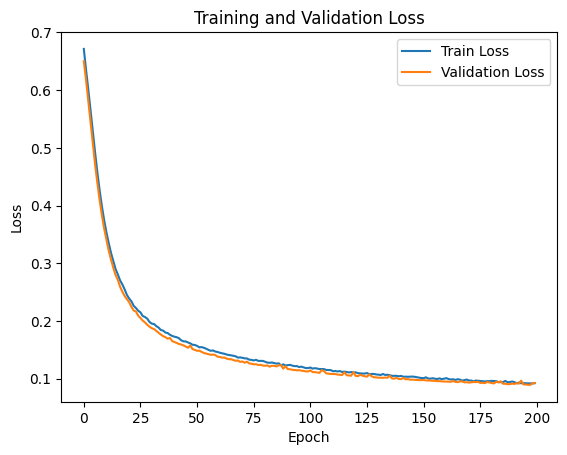

CPU times: user 1min 3s, sys: 1.56 s, total: 1min 5s
Wall time: 1min 5s


MLP(
  (seq): Sequential(
    (0): Linear(in_features=821, out_features=824, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=824, out_features=2, bias=True)
    (4): LogSoftmax(dim=-1)
  )
)

In [36]:
%time train(module, optimizer, criterion, train_dataloader, eval_dataloader, epochs=max_epochs)

In [37]:
# Evaluation on testdata  
best_model = MLP()
best_model.load_state_dict(torch.load('./MLP_big/best-model-parameters.pt', map_location=torch.device('cpu'))) # change Path
best_model.eval()

test_loss = 0
y_true_test = []
y_pred_test = []
for xb, yb in test_dataloader:
    with torch.no_grad():
        outputs = best_model(xb)
        loss = criterion(outputs, yb)
        test_loss += loss.detach().item()

        # Calculate predictions
        _, predicted = torch.max(outputs, 1)
        y_true_test.extend(yb.numpy())
        y_pred_test.extend(predicted.numpy())

test_loss_total = test_loss / len(test_dataloader)
f1_test = f1_score(y_true_test, y_pred_test)
print(f"Test Loss: {test_loss_total:.4f}, F1 Score (Test): {f1_test:.4f}")

Test Loss: 24.6913, F1 Score (Test): 0.9523
